# _Decision Tree_

L'algorithme _Decision Tree_ CART est un algorithme de classification qui crée un arbre. À chaque nœud, on associe un seuil de discrimination ainsi qu'une feature associée à ce seuil. On stocke à chaque feuille la distribution des éléments en fonctions des classes.

CART construit donc un arbre binaire, qui classifie les éléments en les faisant tomber depuis la racine de l'arbre, ils passent ou ne passent pas les seuils des nœuds. Leur arrivée dans une feuille leur donne une classe. La construction d'un tel arbre n'est pas abordée ici. [Ce notebook](Criterion.ipynb) traite de la construction de ces arbres ainsi que des différents critères implémentés. Le critère le plus commun est ici utilisé : _gini_.

[Retour au sommaire](../README.md#table-des-matières)

## Chargement des données

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier

if os.getcwd().endswith("docs"):
    sys.path.append(os.path.join(os.getcwd(), ".."))

from ias import PCA, split_dataset, DecisionTree
from ias.Datasets import Emnist, Iris
from ias.Metrics import accuracy_score, confusion_matrix, cross_validation, show_confusion_matrix

In [2]:
iris_train_x, iris_train_y, iris_test_x, iris_test_y = split_dataset(0.6, Iris)

## Exemple sur Iris

On construit un `DecisionTree` sans hyper-paramètres ainsi que son équivalent `sklean` afin de les comparer.

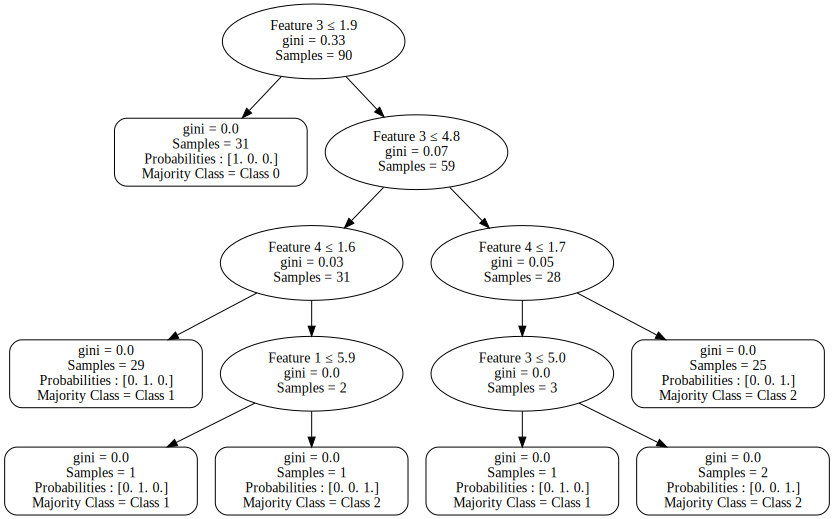

In [3]:
iris_tree = DecisionTree()
iris_tree.fit(iris_train_x, iris_train_y)

sk_iris_tree = DecisionTreeClassifier()
sk_iris_tree = sk_iris_tree.fit(iris_train_x, iris_train_y)

# Affichage du DecisionTree créé
iris_tree.show()

Par défaut `DecisionTree` produit un arbre où lors de l'entrainement, toutes les feuilles finiront par être 'pures'. On appelle 'pures' des feuilles dont tous les elements sont de la même classe ; le vecteur de probabilité est alors trivial. Cependant, ce comportement peut être à l'origine d'_overfitting_.

In [4]:
iris_test_accuracy = accuracy_score(iris_test_y, iris_tree.predict(iris_test_x))
iris_train_accuracy = accuracy_score(iris_train_y, iris_tree.predict(iris_train_x))

sk_iris_test_accuracy = accuracy_score(iris_test_y, sk_iris_tree.predict(iris_test_x))
sk_iris_train_accuracy = accuracy_score(iris_train_y, sk_iris_tree.predict(iris_train_x))

print(f"Score sur l'ensemble d'entrainement : {iris_train_accuracy:.4f}")
print(f"Score sur l'ensemble de test :        {iris_test_accuracy:.4f}")
print(f"Score sur l'ensemble d'entrainement : {sk_iris_train_accuracy:.4f} (sklearn) ")
print(f"Score sur l'ensemble de test :        {sk_iris_test_accuracy:.4f} (sklearn) ")


Score sur l'ensemble d'entrainement : 1.0000
Score sur l'ensemble de test :        0.9500
Score sur l'ensemble d'entrainement : 1.0000 (sklearn) 
Score sur l'ensemble de test :        0.9667 (sklearn) 


On remarque que ces résultats sont quasi-semblables !

Afin d'accélérer les calculs, et aussi pour limiter la taille de l'arbre, on peut utiliser l'hyper-paramètre `max_depth`. Ce dernier fixe une limite sur le nombre "d'étages" maximum qu'un arbre peut avoir.

Optimisons cet hyper-paramètre pour le _dataset_ Iris.

In [5]:
iris_max_depth_values = np.arange(1, 11)
iris_score_by_depth = np.zeros(len(iris_max_depth_values))

for index, max_depth in enumerate(iris_max_depth_values):
    tree = DecisionTree(max_depth=max_depth)
    iris_score_by_depth[index] = cross_validation(tree, iris_train_x, iris_train_y, 10).mean()

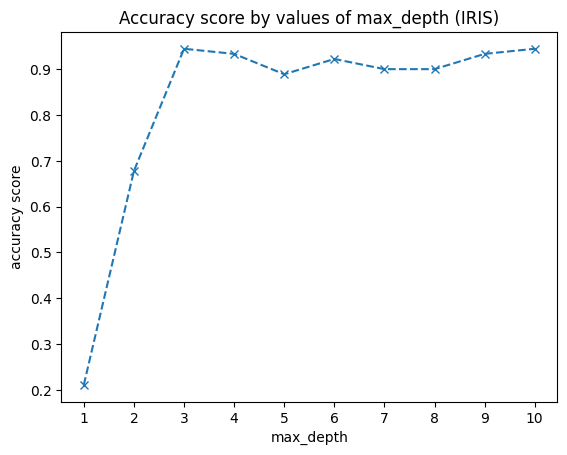

In [6]:
plt.plot(iris_max_depth_values, iris_score_by_depth, "--x")
plt.xticks(iris_max_depth_values)
plt.title("Accuracy score by values of max_depth (IRIS)")
plt.xlabel("max_depth")
plt.ylabel("accuracy score")
plt.show()

On remarque qu'à partir de `max_depth=4`, les résultats sont sensiblement les mêmes, voire moins bon. On choisit alors cette valeur.

Score : 0.917


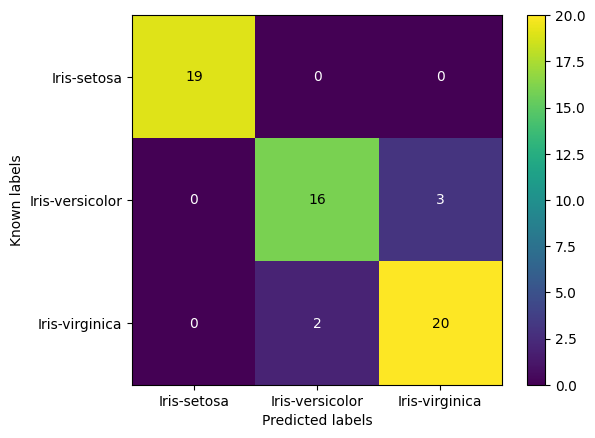

In [7]:
optimized_iris_tree = DecisionTree(max_depth=4)
optimized_iris_tree.fit(iris_train_x, iris_train_y)

predicted_iris_y = optimized_iris_tree.predict(iris_test_x)

iris_confusion_matrix = confusion_matrix(Iris.class_number, iris_test_y, predicted_iris_y)

show_confusion_matrix(iris_confusion_matrix, Iris.class_names)
print(f"Score : {accuracy_score(iris_test_y, predicted_iris_y):.3}")

Nous avons bien un modèle efficace à la résolution du problème de classification _Iris_.

## Comparaison sur EMNIST


Comparons maintenant notre implémentation des `DecisionTree` sur un dataset plus conséquent _EMNIST_.

Vu la lenteur de l'entrainement, on se contentera d'un jeu d'entrainement composé de seulement 1000 éléments avec une repartition des classes quasi-équitable.

In [8]:
emnist_train_x, emnist_train_y, emnist_test_x, emnist_test_y = split_dataset(1000, Emnist)

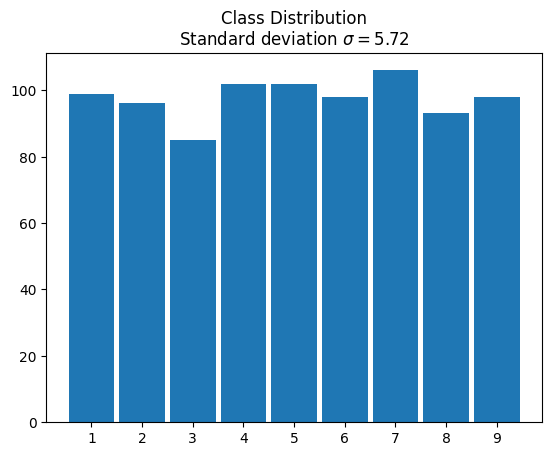

In [9]:
distribution, _, _ = plt.hist(emnist_train_y, bins=np.arange(0.5, 10.5), rwidth=0.9)
plt.xticks(np.arange(1, 10))
plt.title(f"Class Distribution\nStandard deviation $\sigma={distribution.std().round(2)}$")
plt.show()

Nous avons bien une distribution quasiment uniformément répartie puisque $\sigma \ll 100$.

Afin de réduire la dimension des données, on utilise ici une PCA gardant 85% de la variance des données. Pour plus d'information sur l'implémentation rendez-vous sur [ce jupyter notebook](PCA.ipynb).

In [10]:
pca = PCA(0.90)
pca.fit(emnist_train_x)

emnist_compressed_train_x = pca.compress(emnist_train_x)
emnist_compressed_test_x = pca.compress(emnist_test_x)

On cherche maintenant le `max_depth` le plus adapté au dataset _EMNIST_. On utilise ici les `DecisionTreeClassifier` de `sklearn` afin d'accélérer les calculs (~3 minutes sur un bon ordinateur avec notre implémentation). Toujours, pour accélérer les calculs, on ne traite que les multiples de 2.

In [11]:
emnist_max_depth_values = np.arange(1, 16) * 2
emnist_score_by_depth = np.zeros(len(emnist_max_depth_values))

for index, max_depth in enumerate(emnist_max_depth_values):
    tree = DecisionTreeClassifier(max_depth=max_depth)
    emnist_score_by_depth[index] = cross_validation(tree, emnist_compressed_train_x,
                                                    emnist_train_y, 5).mean()

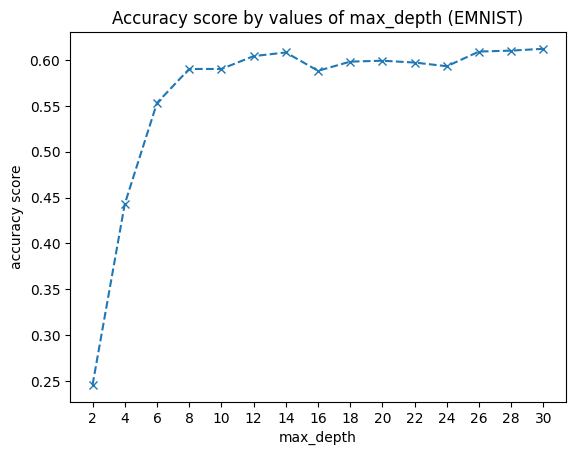

In [12]:
plt.plot(emnist_max_depth_values, emnist_score_by_depth, "--x")
plt.xticks(emnist_max_depth_values)
plt.title("Accuracy score by values of max_depth (EMNIST)")
plt.xlabel("max_depth")
plt.ylabel("accuracy score")
plt.show()

Ainsi, `max_depth=8` semple un bon choix pour le dataset _EMNIST_. On compare alors les deux implémentations :

In [13]:
emnist_tree = DecisionTree(max_depth=8)
emnist_tree.fit(emnist_compressed_train_x, emnist_train_y)

emnist_test_prediction = emnist_tree.predict(emnist_compressed_test_x)
emnist_train_prediction = emnist_tree.predict(emnist_compressed_train_x)

sk_emnist_tree = DecisionTreeClassifier(max_depth=8)
sk_emnist_tree.fit(emnist_compressed_train_x, emnist_train_y)

sk_emnist_test_prediction = sk_emnist_tree.predict(emnist_compressed_test_x)
sk_emnist_train_prediction = sk_emnist_tree.predict(emnist_compressed_train_x)

In [14]:
emnist_test_accuracy = accuracy_score(emnist_test_y, emnist_test_prediction)
emnist_train_accuracy = accuracy_score(emnist_train_y, emnist_train_prediction)

sk_emnist_test_accuracy = accuracy_score(emnist_test_y, sk_emnist_test_prediction)
sk_emnist_train_accuracy = accuracy_score(emnist_train_y, sk_emnist_train_prediction)

print(f"Score sur l'ensemble d'entrainement : {emnist_train_accuracy:.4f}")
print(f"Score sur l'ensemble de test :        {emnist_test_accuracy:.4f}")
print(f"Score sur l'ensemble d'entrainement : {sk_emnist_train_accuracy:.4f} (sklearn) ")
print(f"Score sur l'ensemble de test :        {sk_emnist_test_accuracy:.4f} (sklearn) ")


Score sur l'ensemble d'entrainement : 0.7430
Score sur l'ensemble de test :        0.5981
Score sur l'ensemble d'entrainement : 0.8130 (sklearn) 
Score sur l'ensemble de test :        0.6166 (sklearn) 


Notre implémentation est belle et bien proche de celle de sklearn. L'amélioration des scores de sklearn, peut venir du _pruning_, ou juste d'une meilleure detection des coupages.

On remarque ici que l'_overfitting_ est présent, mais reste maitrisé (~0.1 points de différences en _accuracy score_). On expose ci-dessous les matrices de confusions normalisées sur les ensembles de test.

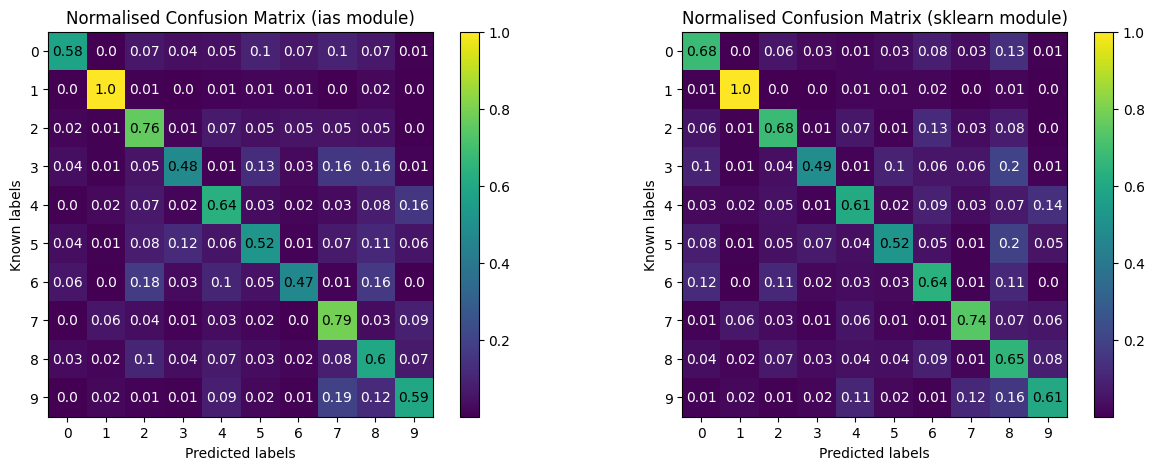

In [15]:
emnist_confusion_matrix = confusion_matrix(Emnist.class_number, emnist_test_y, emnist_test_prediction)
sk_emnist_confusion_matrix = confusion_matrix(Emnist.class_number, emnist_test_y, sk_emnist_test_prediction)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title("Normalised Confusion Matrix (ias module)")
show_confusion_matrix(emnist_confusion_matrix, Emnist.class_names, ax=ax1, round_decimal=2)

ax2.set_title("Normalised Confusion Matrix (sklearn module)")
_ = show_confusion_matrix(sk_emnist_confusion_matrix, Emnist.class_names, ax=ax2, round_decimal=2)

## Conclusions

Notre implémentation est valide et donne des résultats qui correspond à ceux attendus. Pour une exploration et comparaison des critères implémentés, rendez-vous sur [ce notebook](Criterion.ipynb).

[Retour au sommaire](../README.md#table-des-matières)